## 1. Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import os 
from functools import reduce
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [2]:
folder_path = '/Users/AnhHuynh/Documents/CS504-006-Team2/data/monthly_data'  # Replace with your path
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

csv_dfs = []

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    # Convert to datetime
    df['observation_date'] = pd.to_datetime(df['observation_date'])

    csv_dfs.append(df)

In [3]:
gdp = pd.read_csv("data/GDPC1-quarterly.csv")

gdp['observation_date'] = pd.to_datetime(gdp['observation_date'])

gdp.set_index('observation_date', inplace=True)


## 2. Transform quarterly data to monthly data

* Since GDP is a flow varialbe (measured over a period of time), it's best to repeat the quarterly amount for each month within that quarter

In [4]:
gdp_monthly = gdp.resample('MS').ffill()
gdp_monthly.loc['2012-11-01', 'GDPC1'] = gdp_monthly.loc['2012-10-01', 'GDPC1']
gdp_monthly.loc['2012-12-01', 'GDPC1'] = gdp_monthly.loc['2012-10-01', 'GDPC1']
# Reset index and rename the 'date' column to 'observation_date'
gdp_monthly.reset_index(inplace=True)

In [5]:
# Check the min and max date range for gdp_monthly
print("GDP Monthly Date Range:")
print("Start Date:", gdp_monthly['observation_date'].min())
print("End Date:", gdp_monthly['observation_date'].max())


GDP Monthly Date Range:
Start Date: 2006-01-01 00:00:00
End Date: 2012-12-01 00:00:00


## 3. Transform daily data to monthly data

In [6]:
T10Y3M = pd.read_csv("data/T10Y3M-dailycsv.csv")

T10Y3M['observation_date'] = pd.to_datetime(T10Y3M['observation_date'])

# Resample to monthly (you can also use 'sum', 'max', etc.)
T10Y3M_monthly = T10Y3M.resample('MS', on='observation_date').mean().reset_index()

In [7]:
for i, df in enumerate(csv_dfs + [gdp_monthly, T10Y3M_monthly]):
    print(f"DataFrame {i} columns: {df.columns.tolist()}")

DataFrame 0 columns: ['observation_date', 'CSUSHPINSA']
DataFrame 1 columns: ['observation_date', 'HOUST']
DataFrame 2 columns: ['observation_date', 'MSACSRNSA']
DataFrame 3 columns: ['observation_date', 'USREC']
DataFrame 4 columns: ['observation_date', 'FEDFUNDS']
DataFrame 5 columns: ['observation_date', 'RPI']
DataFrame 6 columns: ['observation_date', 'PCEPI']
DataFrame 7 columns: ['observation_date', 'GDPC1']
DataFrame 8 columns: ['observation_date', 'T10Y3M']


## 4. Combine all dataframes

In [8]:
# # # Standardize dates to first of the month
for df in csv_dfs + [gdp_monthly, T10Y3M_monthly]:
    df['observation_date'] = pd.to_datetime(df['observation_date']).dt.to_period('M').dt.to_timestamp()
all_dfs = csv_dfs + [gdp_monthly, T10Y3M_monthly]

In [9]:
merged_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date', how='outer'), all_dfs)

# --- Step 4: Sort and export ---
merged_df.sort_values('observation_date', inplace=True)
merged_df.reset_index(drop=True, inplace=True)

# Output preview
print(merged_df.head(50))


   observation_date  CSUSHPINSA  HOUST  MSACSRNSA  USREC  FEDFUNDS        RPI  \
0        2006-01-01     180.828   2273        5.9      0      4.29  13214.527   
1        2006-02-01     181.500   2119        6.1      0      4.49  13283.182   
2        2006-03-01     182.749   1969        5.1      0      4.59  13340.072   
3        2006-04-01     183.648   1821        5.6      0      4.79  13347.045   
4        2006-05-01     184.380   1942        5.5      0      4.94  13336.874   
5        2006-06-01     184.547   1802        5.8      0      4.99  13353.303   
6        2006-07-01     184.607   1737        6.9      0      5.24  13342.387   
7        2006-08-01     184.404   1650        6.5      0      5.25  13329.621   
8        2006-09-01     184.198   1720        7.0      0      5.25  13408.301   
9        2006-10-01     184.053   1491        7.5      0      5.25  13479.950   
10       2006-11-01     183.630   1570        7.8      0      5.25  13547.935   
11       2006-12-01     183.

## 5. Save as a csv file

In [10]:
merged_df.to_csv("combined_dataset.csv", index=False)

## 6. Exploratory Cleansing

In [11]:
# Read data
data = pd.read_csv("combined_dataset.csv")

data.head()

,observation_date,CSUSHPINSA,HOUST,MSACSRNSA,USREC,FEDFUNDS,RPI,PCEPI,GDPC1,T10Y3M
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,16353.835,0.080000
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,16353.835,0.029474
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,16353.835,0.096087
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,16396.151,0.268947
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,16396.151,0.273636


In [12]:
# Rename columns for readability
rename_dict = {
    'observation_date': 'Date',
    'CSUSHPINSA': 'house_price_index',
    'HOUST': 'new_private_house_owned',
    'MSACSRNSA': 'home_supply',
    'FEDFUNDS': 'federal_rate',
    'RPI': 'real_income',
    'PCEPI': 'consumption_price_index',
    'USREC': 'recession_indicator',
    'GDPC1': 'gdp',
    'T10Y3M': 'treasury_maturity'
}

data = data.rename(columns=rename_dict)

In [13]:
# Display sample dataset
data.head()

,Date,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,16353.835,0.080000
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,16353.835,0.029474
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,16353.835,0.096087
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,16396.151,0.268947
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,16396.151,0.273636


In [14]:
data['recession_indicator'].unique()

array([0, 1])

In [15]:
# Descriptive statistics
data.describe()

,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,157.274500,941.273810,7.785714,0.214286,1.783929,13943.014560,89.569774,16801.586929,1.857878
std,17.585056,456.058608,2.263548,0.412790,2.171063,446.601342,3.278411,362.437273,1.315366
min,133.991000,478.000000,4.200000,0.000000,0.070000,13214.527000,83.534000,16269.145000,-0.515455
25%,143.156500,587.500000,6.100000,0.000000,0.147500,13608.611500,87.252000,16498.403000,0.526776
50%,148.377000,731.500000,7.550000,0.000000,0.190000,13850.489500,89.745000,16826.295000,2.124286
75%,177.927250,1213.750000,9.300000,0.000000,4.490000,14304.834250,92.263750,16978.476250,3.089341
max,184.607000,2273.000000,14.300000,1.000000,5.260000,15333.647000,95.174000,17489.852000,3.684545


In [16]:
# Checking for null values
data.isnull().sum()

Date                       0
house_price_index          0
new_private_house_owned    0
home_supply                0
recession_indicator        0
federal_rate               0
real_income                0
consumption_price_index    0
gdp                        0
treasury_maturity          0
dtype: int64

In [17]:
# Checking for data types
data.dtypes

Date                        object
house_price_index          float64
new_private_house_owned      int64
home_supply                float64
recession_indicator          int64
federal_rate               float64
real_income                float64
consumption_price_index    float64
gdp                        float64
treasury_maturity          float64
dtype: object

In [18]:
# Transform Date value to correct datetime format
data['Date'] = pd.to_datetime(data['Date'])

In [19]:
data.dtypes

Date                       datetime64[ns]
house_price_index                 float64
new_private_house_owned             int64
home_supply                       float64
recession_indicator                 int64
federal_rate                      float64
real_income                       float64
consumption_price_index           float64
gdp                               float64
treasury_maturity                 float64
dtype: object

## 7. Exploratory Data Analysis

/var/folders/4p/strpkrbd1y782g01xksphyv40000gn/T/ipykernel_12319/2738912161.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


<Axes: >

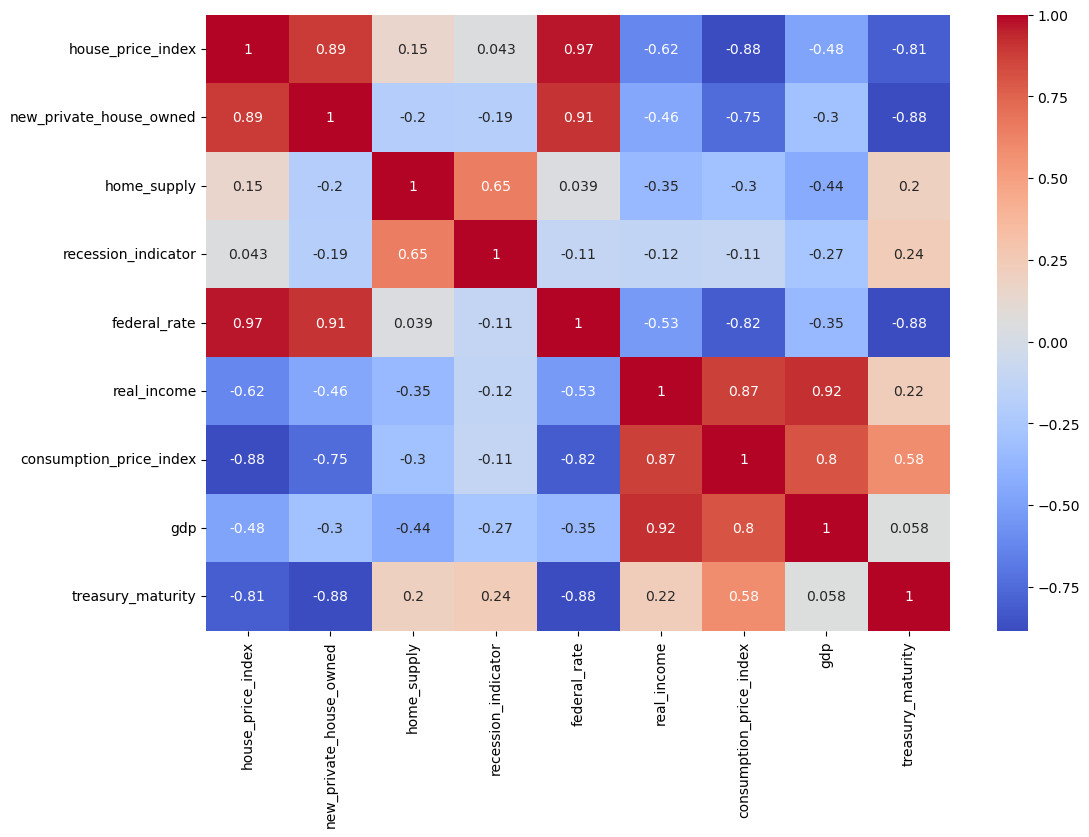

In [20]:
# Correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

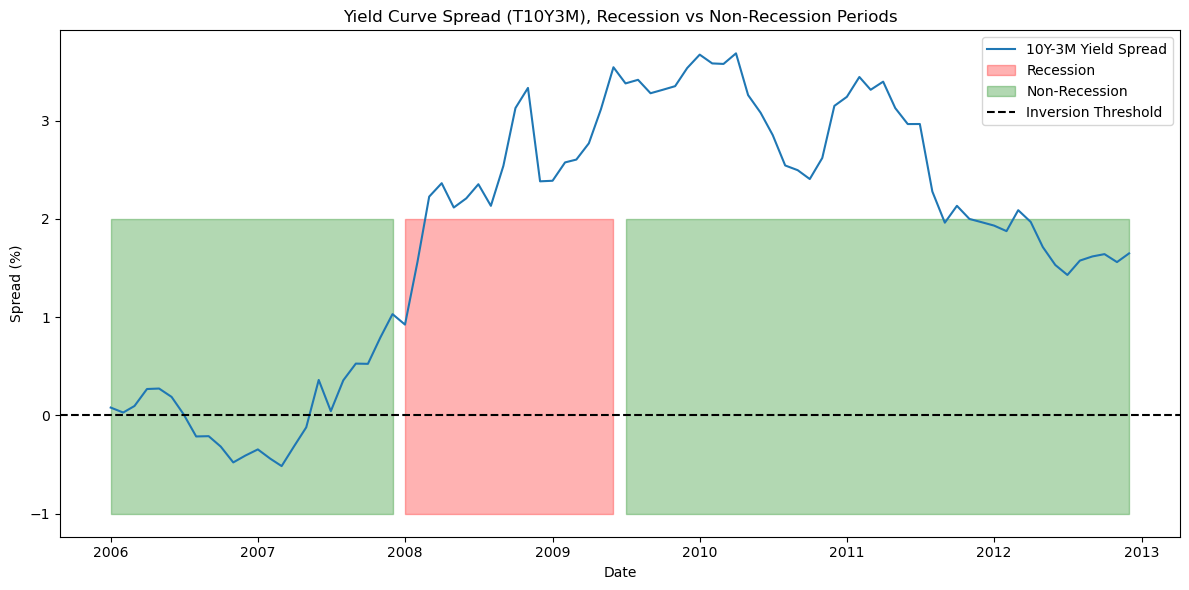

In [21]:
plt.figure(figsize=(12, 6))

# Plot the treasury maturity (yield curve)
sns.lineplot(data=data, x='Date', y='treasury_maturity', label='10Y-3M Yield Spread')

# Highlight recession periods
plt.fill_between(
    data['Date'],
    -1, 2,
    where=data['recession_indicator'] == 1,
    color='red',
    alpha=0.3,
    label='Recession'
)

# Highlight non-recession periods (optional: choose a different color or transparency)
plt.fill_between(
    data['Date'],
    -1, 2,
    where=data['recession_indicator'] == 0,
    color='green',
    alpha=0.3,
    label='Non-Recession'
)

# Horizontal line at 0 to indicate yield curve inversion
plt.axhline(0, linestyle='--', color='black', label='Inversion Threshold')

# Title and labels
plt.title('Yield Curve Spread (T10Y3M), Recession vs Non-Recession Periods')
plt.ylabel('Spread (%)')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
# Compare mean of economic indicators of pre and post 2008 recession
data['period'] = data['Date'].apply(lambda x: 'Pre-2008' if x < pd.to_datetime('2008-01-01') else 'Post-2008')

data.groupby('period')[[
    'house_price_index', 'new_private_house_owned', 'home_supply',
    'federal_rate', 'real_income', 'consumption_price_index', 'gdp'
]].mean()

,house_price_index,new_private_house_owned,home_supply,federal_rate,real_income,consumption_price_index,gdp
period,,,,,,,
Post-2008,147.499517,687.033333,7.906667,0.500833,14087.976550,91.188367,16883.1031
Pre-2008,181.711958,1576.875000,7.483333,4.991667,13580.609583,85.523292,16597.7965


### Interpretation
**House price index**
* The significant drop in the house price index post recession suggests subsequent crash in real-estate during the recession.

**Newly private home owned**
* The decreasing of newly private home owned indicates reduced demands that further leads to hosuing construction plummeted. 

**Home supply** 
* Home supply increased slightly post recession, suggesting slower turnover and potential oversupply. Even fewer homes were built, the low demand led to inventory lingered in the market.

**Federal rate**
* The Federal Reserve slashed interest rate to near 0 to stimulate the economy. This is a classic monetary policy in response to recession.

**Real income**
* The rise in income was counterintuitive. However, stimilus measures, changes in labor market, etc. could explain this.

**Consumption price index**
* Prices continued to rise, indicating consistent inflation.

**GDP**
* GDP post recession surpassed pre recession, suggesting the economy was recovering.


In [23]:
data.head()

,Date,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity,period
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,16353.835,0.080000,Pre-2008
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,16353.835,0.029474,Pre-2008
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,16353.835,0.096087,Pre-2008
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,16396.151,0.268947,Pre-2008
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,16396.151,0.273636,Pre-2008


## 9. Hypothesis Testing

In [24]:
# Hypothesis testing
import statsmodels.api as sm

X = sm.add_constant(data['treasury_maturity'])
y = data['recession_indicator']
model = sm.Logit(y, X).fit()
print(model.summary())


Optimization terminated successfully.
         Current function value: 0.488174
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     recession_indicator   No. Observations:                   84
Model:                           Logit   Df Residuals:                       82
Method:                            MLE   Df Model:                            1
Date:                 Tue, 29 Apr 2025   Pseudo R-squ.:                 0.06044
Time:                         18:35:44   Log-Likelihood:                -41.007
converged:                        True   LL-Null:                       -43.645
Covariance Type:             nonrobust   LLR p-value:                   0.02162
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.3940      0.636     -3.763      0.000      -3.641      -1.147


### Explanation

**Hypothesis**:

* H0: There is no relationship between yield curve and probability of recession.
* H1: There is statistically significant relationship between yield curve and probability of recession.

**Testing metric**

* p-value < 0.05: There is a statistically significant relationship between yield curve and probability of recesssion.
* p-value >= 0.05: There is no relationship between yield curve and probability of recession

**Result**

* In our logistic regression result, the p-value is 0.02162, which is less than 0.05, meaning that there is a statistically significant relationship between yield curve and probability of recession

In [25]:
data.to_csv("data.csv",index=False)

## 10. Ordinary Least Squares (OLS)

* This method is used to identify and quantify how specific economic variables affect the house price index

In [26]:
data['yieldcurve_lag1'] = data['treasury_maturity'].shift(1)
data['yieldcurve_lag3'] = data['treasury_maturity'].shift(3)
data['yieldcurve_lag6'] = data['treasury_maturity'].shift(6)


In [30]:
data = data.dropna(subset=['yieldcurve_lag1', 'yieldcurve_lag3', 'yieldcurve_lag6'])

In [32]:
import statsmodels.api as sm

# Define predictors and target
X = data[[
    'federal_rate',
    'real_income',
    'consumption_price_index',
    'home_supply',
    'gdp',
    'new_private_house_owned',
    'yieldcurve_lag1',
    'yieldcurve_lag3',
    'yieldcurve_lag6'
]]
y = data['house_price_index']

# Add constant for intercept
X = sm.add_constant(X)

# Fit model
model = sm.OLS(y, X).fit()

# Summary of results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:      house_price_index   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.971
Method:                 Least Squares   F-statistic:                     285.0
Date:                Tue, 29 Apr 2025   Prob (F-statistic):           2.31e-50
Time:                        18:50:44   Log-Likelihood:                -187.04
No. Observations:                  78   AIC:                             394.1
Df Residuals:                      68   BIC:                             417.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

#### OLS Regression Result Interpretation

* The R-square and adjusted R-squared suggest that the model explain 97% in house price. 

* The probability of F-statistics is less than 0.0001, indicating that there is at least one predictor is statistically significant. 

* Based on p-values of the independent variables, the predictors that are statistically significant in the model are:
    * Federal rate
    * Home supply
    * Newly private house owned
    * Yield curve lagged 6 months

## 11. Logistic Regression

In [ ]:
X = data[[
    'federal_rate',
    'home_supply',
    'new_private_house_owned',
    'house_price_index'
]]
y = data['recession_indicator']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

In [ ]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[13  1]
 [ 1  2]]
Accuracy: 0.8823529411764706
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93        14
           1       0.67      0.67      0.67         3

    accuracy                           0.88        17
   macro avg       0.80      0.80      0.80        17
weighted avg       0.88      0.88      0.88        17



AUC Score: 0.95


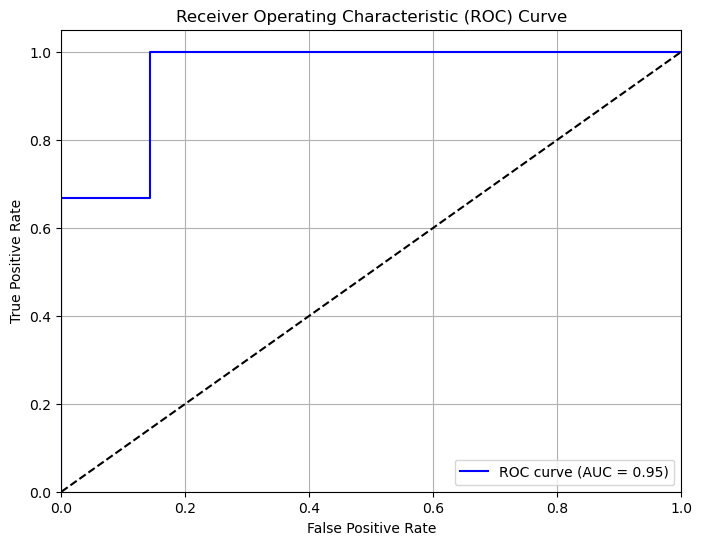

In [ ]:
# Plot ROC
if len(np.unique(y_test)) < 2:
    print("Cannot compute ROC AUC - only one class present in y_test.")
else:
    # Compute ROC curve and AUC score
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    print(f"AUC Score: {auc:.2f}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})', color='blue')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random guessing
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


## 8. Visualization

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.head()

,Date,house_price_index,new_private_house_owned,home_supply,recession_indicator,federal_rate,real_income,consumption_price_index,gdp,treasury_maturity,period
0,2006-01-01,180.828,2273,5.9,0,4.29,13214.527,83.534,16353.835,0.080000,Pre-2008
1,2006-02-01,181.500,2119,6.1,0,4.49,13283.182,83.584,16353.835,0.029474,Pre-2008
2,2006-03-01,182.749,1969,5.1,0,4.59,13340.072,83.746,16353.835,0.096087,Pre-2008
3,2006-04-01,183.648,1821,5.6,0,4.79,13347.045,84.135,16396.151,0.268947,Pre-2008
4,2006-05-01,184.380,1942,5.5,0,4.94,13336.874,84.361,16396.151,0.273636,Pre-2008


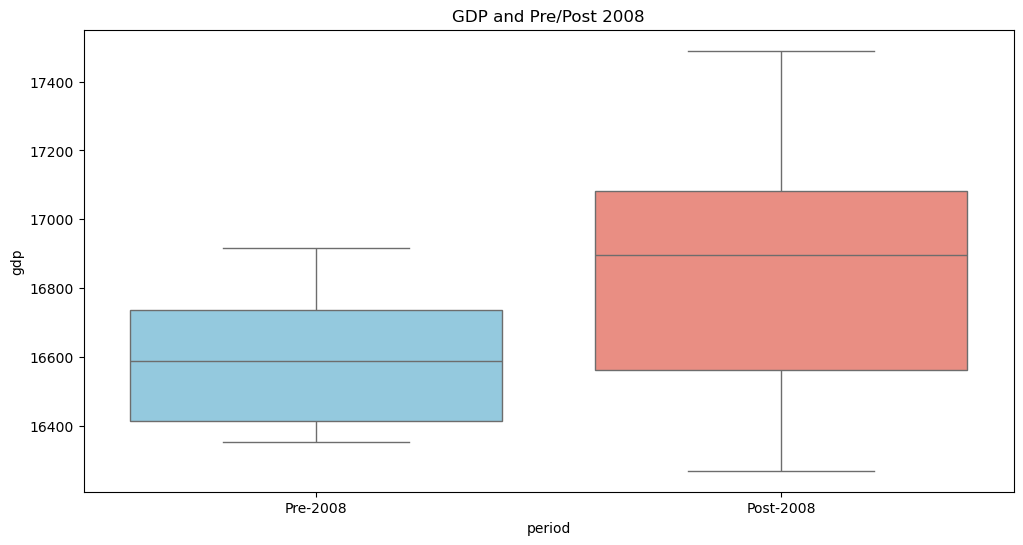

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='period', y='gdp', hue='period', data=df,palette={'Pre-2008': 'skyblue', 'Post-2008': 'salmon'})
plt.title('GDP and Pre/Post 2008')
plt.show()


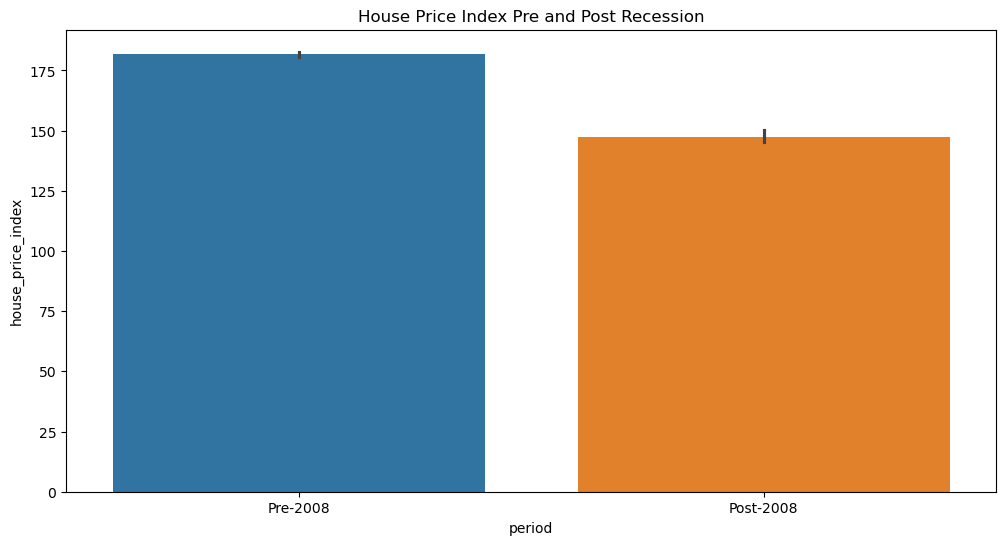

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='period', y='house_price_index', hue='period')
# plt.fill_between(df['Date'], 0, 1, where=df['recession_indicator']==1, color='red', alpha=0.2)
plt.title('House Price Index Pre and Post Recession')
plt.show()


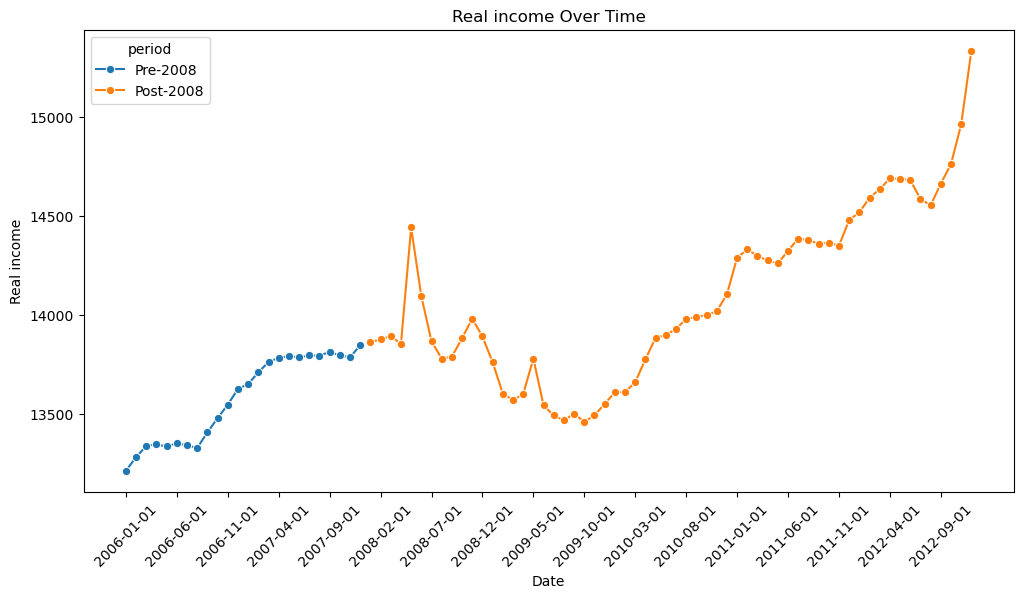

In [ ]:
# Line plot showing trends for a variable (e.g., home_supply)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='real_income', hue='period', marker='o')
plt.title('Real income Over Time')
plt.xlabel('Date')
plt.ylabel('Real income')
plt.xticks(ticks=df['Date'][::5], rotation=45) 
plt.show()


Text(0, 0.5, 'Home Supply')

<Figure size 1200x600 with 0 Axes>

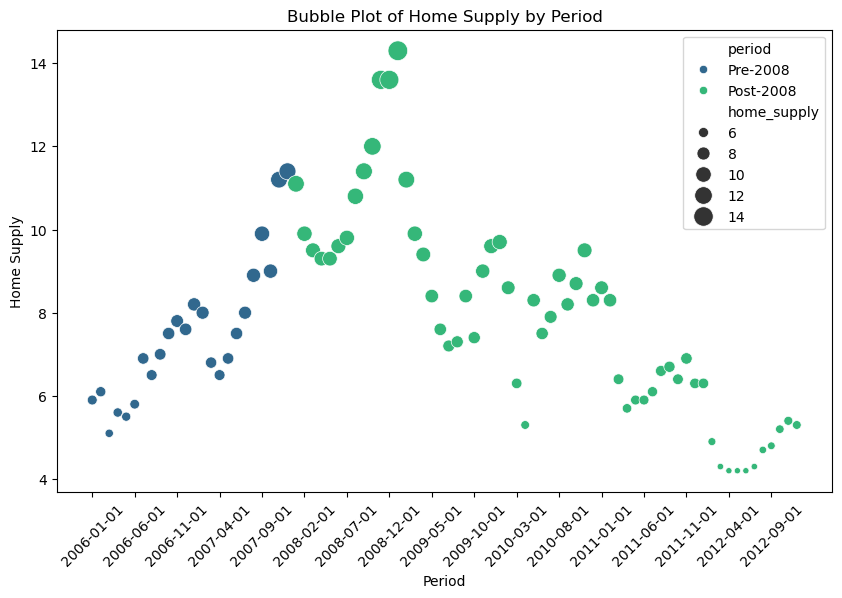

In [ ]:
# Bubble plot where size of the points corresponds to consumption_price_index
plt.figure(figsize=(12,6))
plt.figure(figsize=(10, 6))

# Scatter plot where x is 'period', y is 'home_supply', and the size of bubbles is based on 'home_supply'
sns.scatterplot(data=df, x='Date', y='home_supply', size='home_supply', hue='period', sizes=(20, 200), legend='brief', palette='viridis')

# Set plot title and labels
plt.title('Bubble Plot of Home Supply by Period')
plt.xticks(ticks=df['Date'][::5], rotation=45) 
plt.xlabel('Period')
plt.ylabel('Home Supply')


/var/folders/4p/strpkrbd1y782g01xksphyv40000gn/T/ipykernel_7379/3021886892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='period', y='new_private_house_owned', data=df, palette='muted')


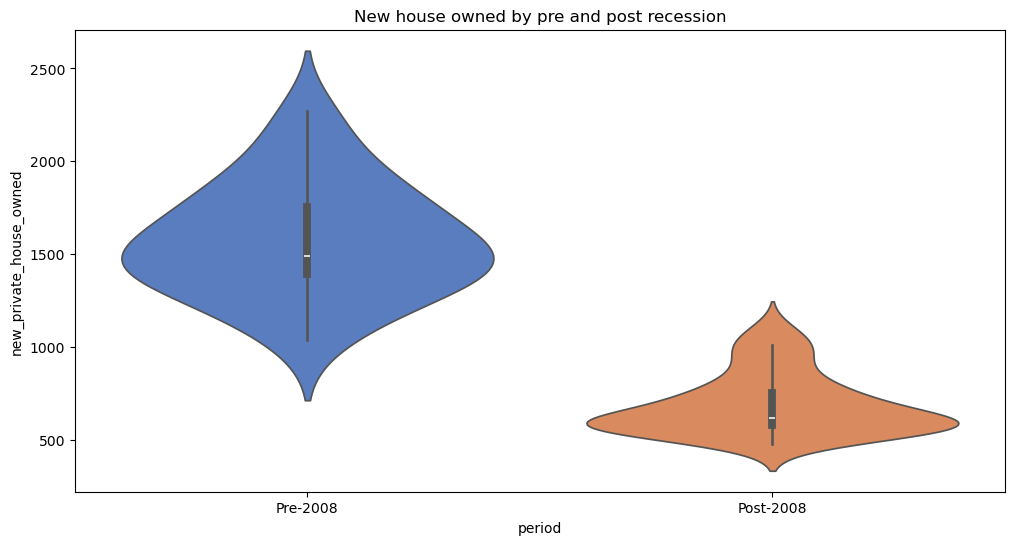

In [ ]:
plt.figure(figsize=(12,6))
sns.violinplot(x='period', y='new_private_house_owned', data=df, palette='muted')
plt.title('New house owned by pre and post recession')
plt.show()


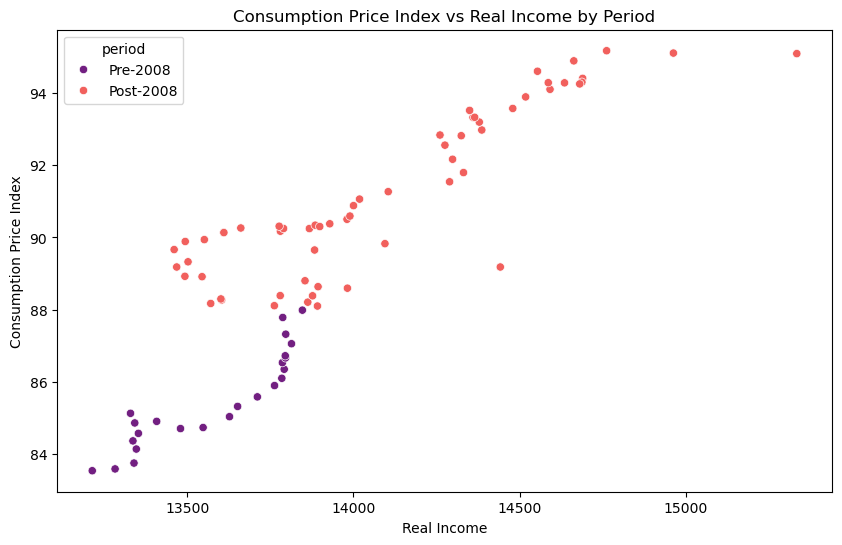

In [ ]:

# Scatter plot of consumption price index vs real income, colored by period
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='real_income', y='consumption_price_index', hue='period', palette='magma')

# Set plot title and labels
plt.title('Consumption Price Index vs Real Income by Period')
plt.xlabel('Real Income')
plt.ylabel('Consumption Price Index')

# Show plot
plt.show()
